In [26]:
import sys
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.training import data_split_augment, train_model
from src.model import *
from src.visualization import *
from main import load_newest_model
from src.loader import load_and_preprocess_image

In [27]:
train_ds, val_ds, class_names = data_split_augment("../data/raw", (224,224), 16)
test_directory = '../data/test/'

Found 360 files belonging to 9 classes.
Using 288 files for training.
Found 360 files belonging to 9 classes.
Using 72 files for validation.


In [28]:
model = load_newest_model(path="../models/")
model.summary()

../models/modelV3.keras loaded


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753,373 (10.50 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 330,260 (1.26 MB)

In [29]:
for layer in model.get_layer('mobilenetv2_1.00_224').layers:
    print(layer.name)

input_layer_2
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_

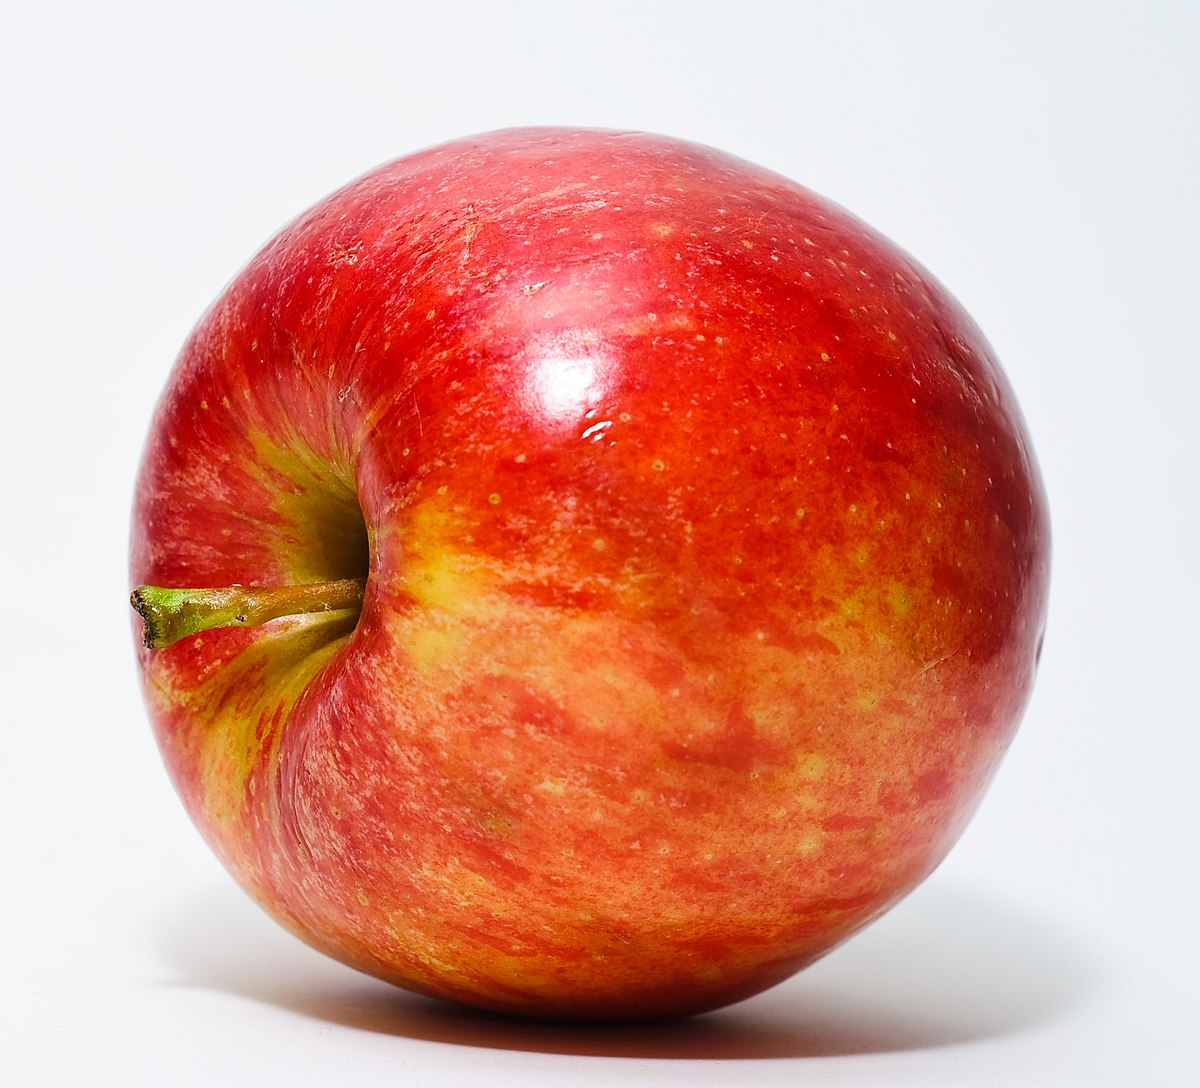

In [30]:
image_path = "../data/test/red_apple.jpg"
image = Image.open(image_path)
display(image)

In [31]:
processed_image = load_and_preprocess_image(image_path)

# get feature maps of early, mid, and last convulational layers
early_fm = get_feature_map(model, layer_name="Conv1", preprocessed_image=processed_image)
mid_fm = get_feature_map(model, layer_name="block_2_expand_relu", preprocessed_image=processed_image)
late_fm = get_feature_map(model, layer_name="Conv_1", preprocessed_image=processed_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step


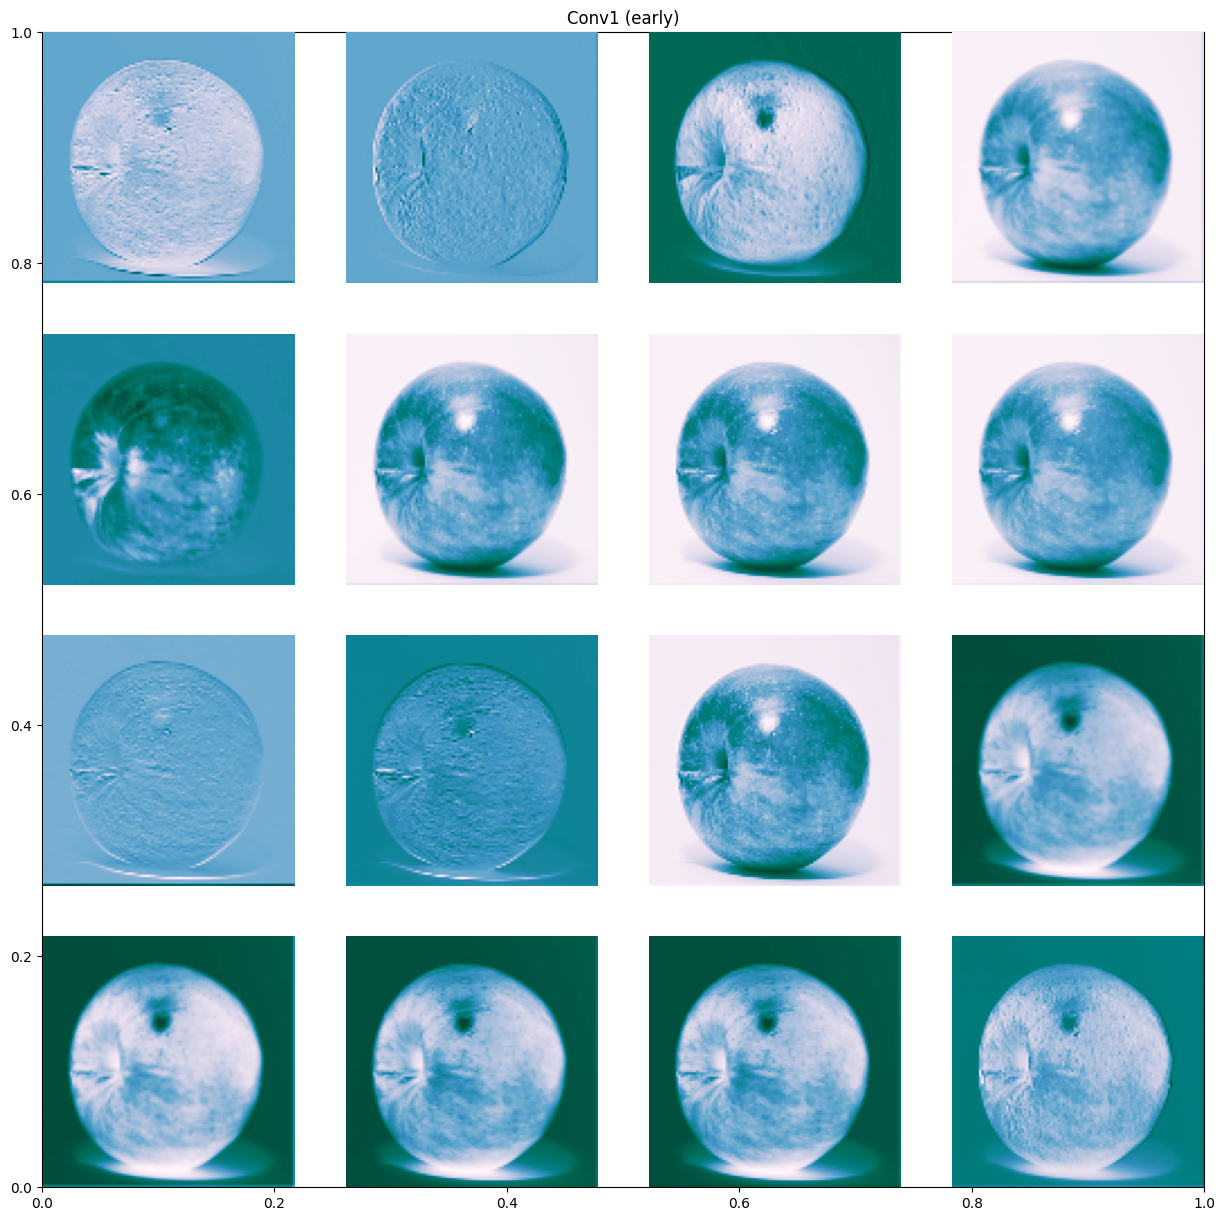

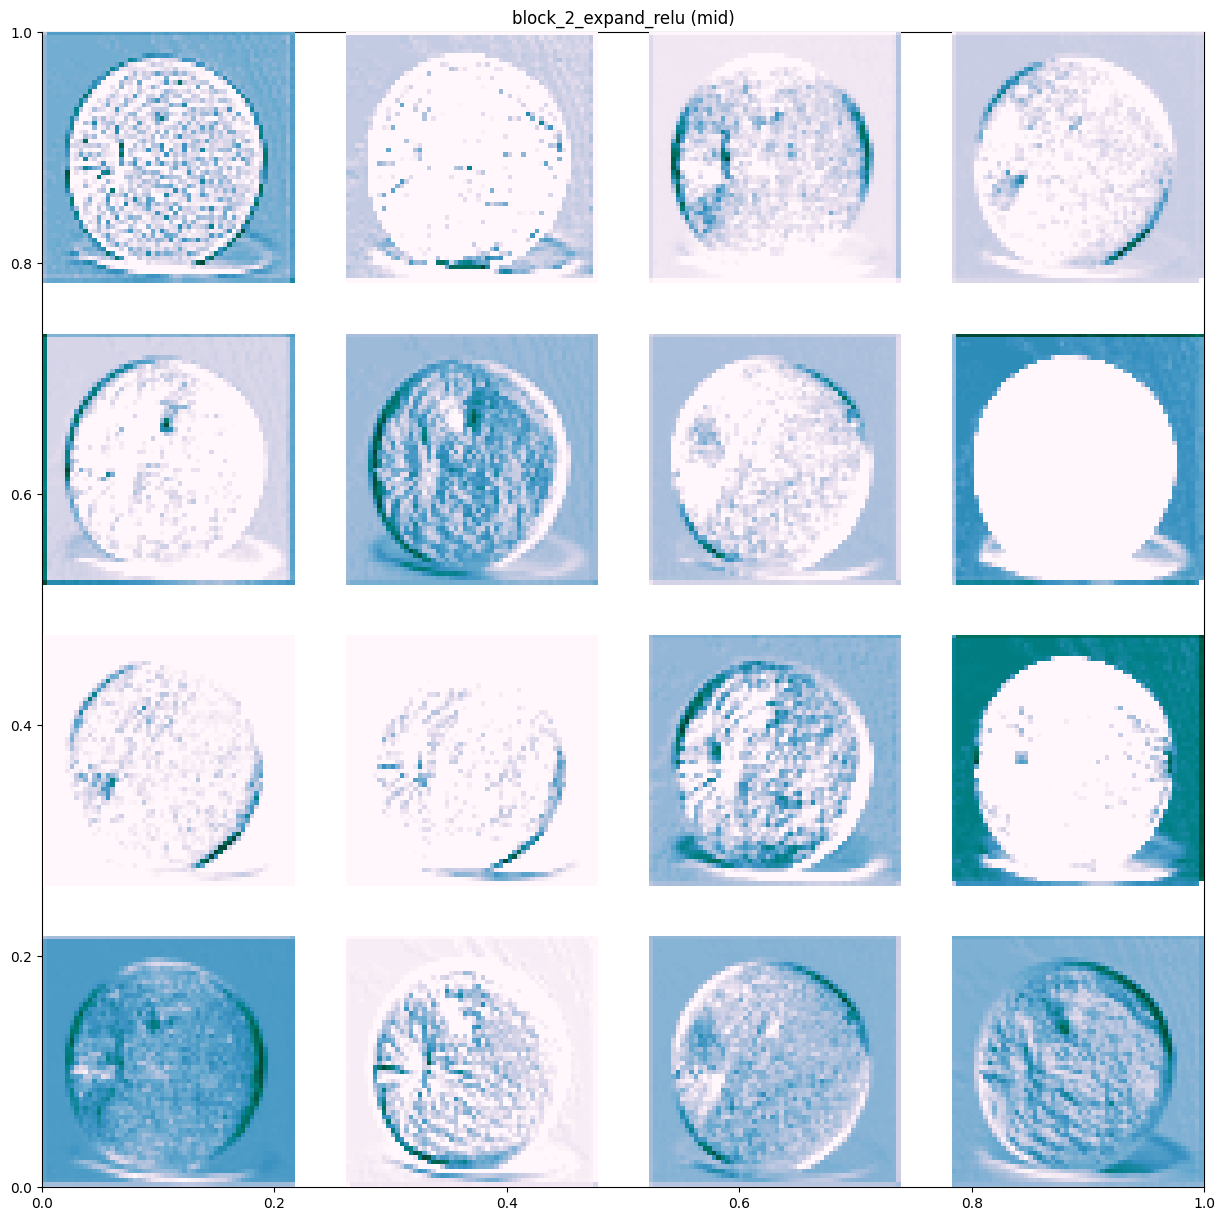

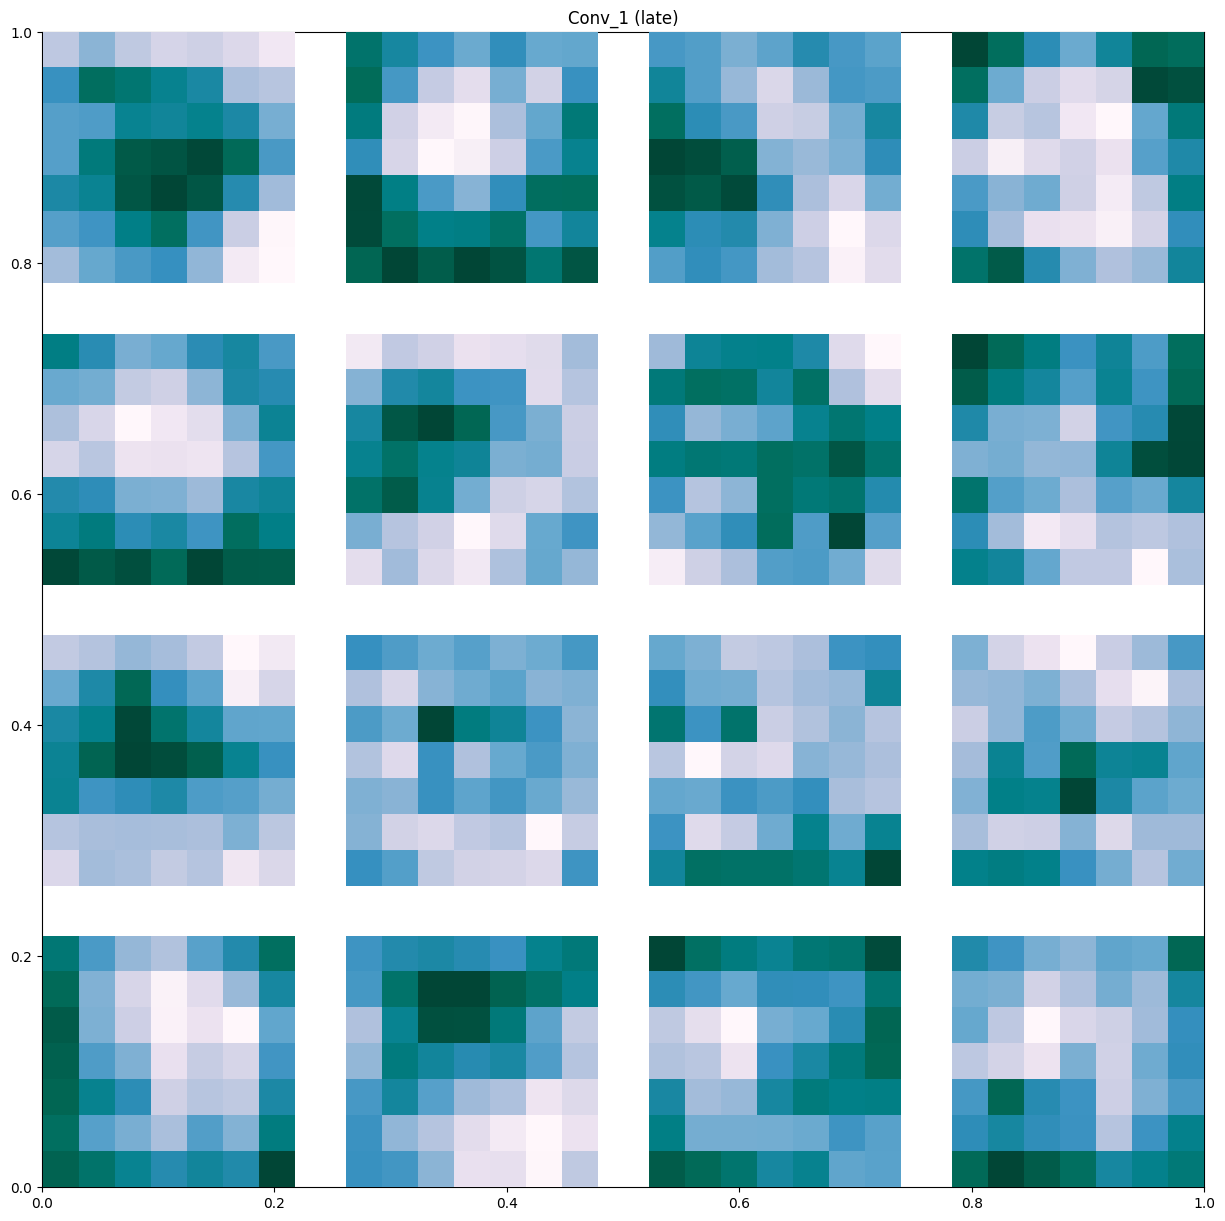

In [32]:
visualize_feature_map(early_fm, "Conv1 (early)")
visualize_feature_map(mid_fm, "block_2_expand_relu (mid)")
visualize_feature_map(late_fm, "Conv_1 (late)")

In [ ]:
def grad_cam(model, last_conv, processed_image, pred_index=None):
    """
    Compute Grad-CAM heatmap for a specific prediction.
    """
    input_tensor = tf.keras.Input(shape=(224, 224, 3))
    model(input_tensor)

    grad_model = tf.keras.models.Model(
        # inputs=model.get_layer("mobilenetv2_1.00_224").input,
        inputs=model.input,
        outputs=[model.get_layer("mobilenetv2_1.00_224").get_layer(last_conv).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(processed_image)
        print(conv_outputs, predictions.shape)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def display_grad_cam(img, heatmap, alpha=0.4):
    """
    Overlay Grad-CAM heatmap on the original image.
    """
    # Resize heatmap to match the image size
    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(heatmap, (img.shape[1], img.shape[2])).numpy()

    # Convert heatmap to RGB
    heatmap = np.expand_dims(heatmap, axis=-1)
    heatmap = np.concatenate([heatmap] * 3, axis=-1)

    # Overlay heatmap on the image
    overlay = heatmap * alpha + img
    overlay = overlay / np.max(overlay)  # Normalize to [0, 1]
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()


In [44]:
layer = 'Conv_1'
heatmap = grad_cam(model, layer , processed_image)
display_grad_cam(processed_image[0], heatmap)

KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m3034202247120\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[[[0.9137255 , 0.92156863, 0.9529412 ],\n         [0.9137255 , 0.92156863, 0.9529412 ],\n         [0.9137255 , 0.92156863, 0.9529412 ],\n         ...,\n         [0.7882353 , 0.84313726, 0.8901961 ],\n         [0.7882353 , 0.84313726, 0.8901961 ],\n         [0.7882353 , 0.84313726, 0.8901961 ]],\n\n        [[0.9137255 , 0.92156863, 0.9529412 ],\n         [0.9137255 , 0.92156863, 0.9529412 ],\n         [0.9137255 , 0.92156863, 0.9529412 ],\n         ...,\n         [0.7882353 , 0.84313726, 0.8901961 ],\n         [0.7882353 , 0.84313726, 0.8901961 ],\n         [0.7882353 , 0.84313726, 0.8901961 ]],\n\n        [[0.9137255 , 0.92156863, 0.9529412 ],\n         [0.9137255 , 0.92156863, 0.9529412 ],\n         [0.9137255 , 0.92156863, 0.9529412 ],\n         ...,\n         [0.7882353 , 0.84313726, 0.8901961 ],\n         [0.7882353 , 0.84313726, 0.8901961 ],\n         [0.7882353 , 0.84313726, 0.8901961 ]],\n\n        ...,\n\n        [[0.9137255 , 0.92156863, 0.9372549 ],\n         [0.9137255 , 0.92156863, 0.9372549 ],\n         [0.9137255 , 0.92156863, 0.9372549 ],\n         ...,\n         [0.8352941 , 0.85882354, 0.8980392 ],\n         [0.8352941 , 0.85882354, 0.8980392 ],\n         [0.8352941 , 0.85882354, 0.8980392 ]],\n\n        [[0.9137255 , 0.92156863, 0.9372549 ],\n         [0.9137255 , 0.92156863, 0.9372549 ],\n         [0.9137255 , 0.92156863, 0.9372549 ],\n         ...,\n         [0.827451  , 0.8509804 , 0.8901961 ],\n         [0.827451  , 0.8509804 , 0.8901961 ],\n         [0.8352941 , 0.85882354, 0.8980392 ]],\n\n        [[0.9137255 , 0.92156863, 0.9372549 ],\n         [0.9137255 , 0.92156863, 0.9372549 ],\n         [0.9137255 , 0.92156863, 0.9372549 ],\n         ...,\n         [0.8352941 , 0.85882354, 0.8980392 ],\n         [0.827451  , 0.8509804 , 0.8901961 ],\n         [0.8352941 , 0.85882354, 0.8980392 ]]]], dtype=float32)\n  • training=None\n  • mask=None'

In [ ]:
kprocessed_image.shape

(1, 224, 224, 3)

In [ ]:
print(processed_image.min(), processed_image.max())  # Should output values between -1 and 1


-1.0 1.0


In [42]:
print(type(processed_image))

<class 'numpy.ndarray'>


In [43]:
base_model = model.get_layer("mobilenetv2_1.00_224")
print([layer.name for layer in base_model.layers])  # Ensure "Conv_1" exists


['input_layer_2', 'Conv1', 'bn_Conv1', 'Conv1_relu', 'expanded_conv_depthwise', 'expanded_conv_depthwise_BN', 'expanded_conv_depthwise_relu', 'expanded_conv_project', 'expanded_conv_project_BN', 'block_1_expand', 'block_1_expand_BN', 'block_1_expand_relu', 'block_1_pad', 'block_1_depthwise', 'block_1_depthwise_BN', 'block_1_depthwise_relu', 'block_1_project', 'block_1_project_BN', 'block_2_expand', 'block_2_expand_BN', 'block_2_expand_relu', 'block_2_depthwise', 'block_2_depthwise_BN', 'block_2_depthwise_relu', 'block_2_project', 'block_2_project_BN', 'block_2_add', 'block_3_expand', 'block_3_expand_BN', 'block_3_expand_relu', 'block_3_pad', 'block_3_depthwise', 'block_3_depthwise_BN', 'block_3_depthwise_relu', 'block_3_project', 'block_3_project_BN', 'block_4_expand', 'block_4_expand_BN', 'block_4_expand_relu', 'block_4_depthwise', 'block_4_depthwise_BN', 'block_4_depthwise_relu', 'block_4_project', 'block_4_project_BN', 'block_4_add', 'block_5_expand', 'block_5_expand_BN', 'block_5_e